# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [ ]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2021-07-20 10:31:01--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  93.9MB/s    in 1.8s    

2021-07-20 10:31:03 (93.9 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-07-20 10:31:03--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M   103MB/s    in 0.6s    

2021-07-20 10:31:04 (103 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2021-07-20 10:31:04--
Total wall clock time: 2.6s
Downloaded: 2 files, 235M in

In [ ]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [ ]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [ ]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [ ]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [ ]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [ ]:
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    # Evaluation mode
    model.eval()
    
    correct = 0
    total = 0
    for x, y in loader:

        x_gpu = x.to(device)
        y_gpu = y.to(device)

        preds = torch.argmax(model(x_gpu), 1)
        correct += torch.sum(preds == y_gpu)
        total += y_gpu.shape[0]
    
    return correct / total

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        if scheduler:
            scheduler.step()
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [ ]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Average loss: 1.372163, Train accuracy: 0.541566, Val accuracy: 0.738516
Average loss: 0.697305, Train accuracy: 0.788793, Val accuracy: 0.799195
Average loss: 0.593399, Train accuracy: 0.823550, Val accuracy: 0.803085
Average loss: 0.547889, Train accuracy: 0.837099, Val accuracy: 0.822538
Average loss: 0.513325, Train accuracy: 0.850203, Val accuracy: 0.817896


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [ ]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1231: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1231: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


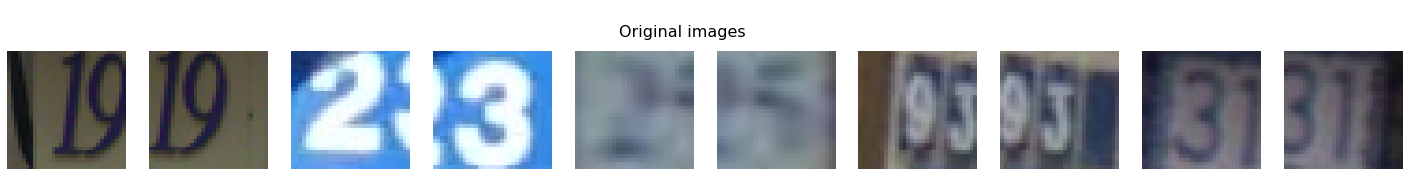

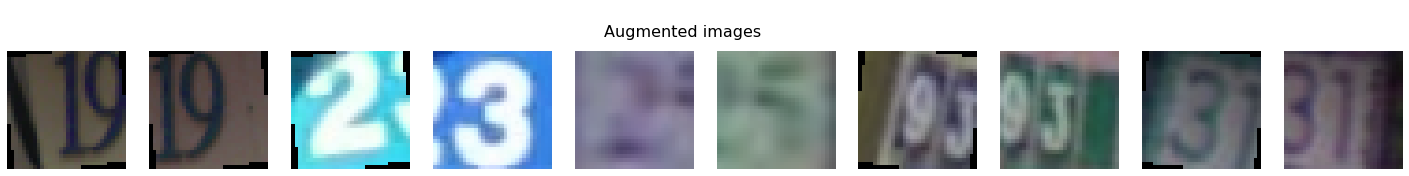

In [ ]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?
fig = plt.figure(figsize=(25, 3))
fig.suptitle('\nOriginal images', fontsize=16)
for i, (x, y) in enumerate(dset.SVHN('./')):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')


tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

fig = plt.figure(figsize=(25, 3))
fig.suptitle('\nAugmented images', fontsize=16)
for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [ ]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                         std=[0.20,0.20,0.20])                           
])

data_aug_train = dset.SVHN(root='./', transform=tfs)

train_aug_loader = torch.utils.data.DataLoader(dataset=data_aug_train, 
                                               batch_size=batch_size, 
                                               sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1231: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [ ]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.617050, Train accuracy: 0.813005, Val accuracy: 0.819057
Average loss: 0.559060, Train accuracy: 0.830171, Val accuracy: 0.802266
Average loss: 0.543055, Train accuracy: 0.835751, Val accuracy: 0.829841
Average loss: 0.521288, Train accuracy: 0.842559, Val accuracy: 0.830114
Average loss: 0.511050, Train accuracy: 0.846569, Val accuracy: 0.834960


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [ ]:
lenet_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
    nn.Tanh(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    nn.Tanh(),
    nn.MaxPool2d(kernel_size=2),
    Flattener(),
    nn.Linear(in_features=5*5*16, out_features=120),
    nn.Linear(in_features=120, out_features=84),
    nn.Linear(in_features=84, out_features=10)
)

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [ ]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.203298, Train accuracy: 0.597294, Val accuracy: 0.813596
Average loss: 0.601230, Train accuracy: 0.815138, Val accuracy: 0.842809
Average loss: 0.548600, Train accuracy: 0.831638, Val accuracy: 0.855709
Average loss: 0.522126, Train accuracy: 0.842405, Val accuracy: 0.847519
Average loss: 0.510057, Train accuracy: 0.846108, Val accuracy: 0.860829
Average loss: 0.492569, Train accuracy: 0.851210, Val accuracy: 0.860010
Average loss: 0.484692, Train accuracy: 0.854401, Val accuracy: 0.864514
Average loss: 0.476210, Train accuracy: 0.854998, Val accuracy: 0.858849
Average loss: 0.473811, Train accuracy: 0.856312, Val accuracy: 0.866221
Average loss: 0.468664, Train accuracy: 0.858052, Val accuracy: 0.870384


# Подбор гиперпараметров

In [ ]:
model = nn.Sequential(
    # Input: 3@32x32
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2),
    nn.BatchNorm2d(num_features=16),
    nn.Tanh(),
    # Res: 16@32x32
    nn.MaxPool2d(kernel_size=2),
    # Res: 16@16x16
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
    nn.BatchNorm2d(num_features=32),
    nn.Tanh(),
    # Res: 32@14x14
    nn.MaxPool2d(kernel_size=2),
    # Res: 32@7x7
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.BatchNorm2d(num_features=64),
    nn.Tanh(),
    # Res: 64@5X5
    Flattener(),

    nn.Linear(in_features=5*5*64, out_features=120),
    nn.BatchNorm1d(num_features=120),
    nn.ReLU(inplace=True),

    nn.Linear(in_features=120, out_features=84),
    nn.BatchNorm1d(num_features=84),
    nn.ReLU(inplace=True),

    nn.Linear(in_features=84, out_features=10)
)

model.type(torch.cuda.FloatTensor)
model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4)

loss_history, train_history, val_history = train_model(model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 0.758303, Train accuracy: 0.759188, Val accuracy: 0.870384
Average loss: 0.431753, Train accuracy: 0.867949, Val accuracy: 0.893045
Average loss: 0.366043, Train accuracy: 0.887878, Val accuracy: 0.904034
Average loss: 0.332044, Train accuracy: 0.899567, Val accuracy: 0.906150
Average loss: 0.302971, Train accuracy: 0.906580, Val accuracy: 0.910040
Average loss: 0.281875, Train accuracy: 0.913592, Val accuracy: 0.915296
Average loss: 0.265429, Train accuracy: 0.918217, Val accuracy: 0.914545
Average loss: 0.250237, Train accuracy: 0.924820, Val accuracy: 0.919391
Average loss: 0.238164, Train accuracy: 0.927670, Val accuracy: 0.915842
Average loss: 0.226292, Train accuracy: 0.932481, Val accuracy: 0.917275


In [ ]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

# Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
# anneal_coeff = 0.2
# anneal_epochs = [1, 5, 10, 15, 20, 50]
reg_strengths = [1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

def param_search(run_record, learning_rates, reg_strengths, num_epochs=10):
  for lr in learning_rates:
    for reg in reg_strengths:
      
      model = nn.Sequential(
        # Input: 3@32x32
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2),
        nn.BatchNorm2d(num_features=16),
        nn.Tanh(),
        # Res: 16@32x32
        nn.MaxPool2d(kernel_size=2),
        # Res: 16@16x16
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        nn.BatchNorm2d(num_features=32),
        nn.Tanh(),
        # Res: 32@14x14
        nn.MaxPool2d(kernel_size=2),
        # Res: 32@7x7
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(num_features=64),
        nn.Tanh(),
        # Res: 64@5X5
        Flattener(),

        nn.Linear(in_features=5*5*64, out_features=120),
        nn.BatchNorm1d(num_features=120),
        nn.ReLU(inplace=True),

        nn.Linear(in_features=120, out_features=84),
        nn.BatchNorm1d(num_features=84),
        nn.ReLU(inplace=True),

        nn.Linear(in_features=84, out_features=10)
      )
      
      model.type(torch.cuda.FloatTensor)
      model.to(device)

      loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
      optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg)

      params = Hyperparams(lr, reg)

      loss_history, train_history, val_history = train_model(model, train_aug_loader, val_loader, loss, optimizer, num_epochs)

      run_results = RunResult(model, train_history, val_history, val_history[-1])

      run_record[params] = run_results

      print('\n\n')

In [ ]:
# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

param_search(run_record=run_record, learning_rates=learning_rates, reg_strengths=reg)

Average loss: 0.856512, Train accuracy: 0.721530, Val accuracy: 0.843901
Average loss: 0.525944, Train accuracy: 0.836058, Val accuracy: 0.857075
Average loss: 0.498745, Train accuracy: 0.844453, Val accuracy: 0.854276
Average loss: 0.479893, Train accuracy: 0.852575, Val accuracy: 0.869292
Average loss: 0.471364, Train accuracy: 0.853018, Val accuracy: 0.847587
Average loss: 0.465752, Train accuracy: 0.855749, Val accuracy: 0.868337
Average loss: 0.464520, Train accuracy: 0.855663, Val accuracy: 0.861716
Average loss: 0.463144, Train accuracy: 0.856824, Val accuracy: 0.870179
Average loss: 0.458233, Train accuracy: 0.857591, Val accuracy: 0.839670
Average loss: 0.456593, Train accuracy: 0.858871, Val accuracy: 0.886015



Average loss: 0.828486, Train accuracy: 0.727332, Val accuracy: 0.870111
Average loss: 0.441853, Train accuracy: 0.864348, Val accuracy: 0.893864
Average loss: 0.376816, Train accuracy: 0.884568, Val accuracy: 0.907378
Average loss: 0.341284, Train accuracy: 0.894942

In [ ]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.92, best hyperparams: Hyperparams(learning_rate=1.0, reg=1e-07)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [ ]:
best_model = nn.Sequential(
  # Input: 3@32x32
  nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2),
  nn.BatchNorm2d(num_features=16),
  nn.Tanh(),
  # Res: 16@32x32
  nn.MaxPool2d(kernel_size=2),
  # Res: 16@16x16
  nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
  nn.BatchNorm2d(num_features=32),
  nn.Tanh(),
  # Res: 32@14x14
  nn.MaxPool2d(kernel_size=2),
  # Res: 32@7x7
  nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
  nn.BatchNorm2d(num_features=64),
  nn.Tanh(),
  # Res: 64@5X5
  Flattener(),

  nn.Linear(in_features=5*5*64, out_features=120),
  nn.BatchNorm1d(num_features=120),
  nn.ReLU(inplace=True),

  nn.Linear(in_features=120, out_features=84),
  nn.BatchNorm1d(num_features=84),
  nn.ReLU(inplace=True),

  nn.Linear(in_features=84, out_features=10)
)

best_model.type(torch.cuda.FloatTensor)
best_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(best_model.parameters(), lr=1.0, weight_decay=1e-07)

loss_history, train_history, val_history = train_model(best_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 0.847025, Train accuracy: 0.722196, Val accuracy: 0.869565
Average loss: 0.431078, Train accuracy: 0.866754, Val accuracy: 0.895365
Average loss: 0.358174, Train accuracy: 0.890660, Val accuracy: 0.904034
Average loss: 0.322476, Train accuracy: 0.901887, Val accuracy: 0.912907
Average loss: 0.298565, Train accuracy: 0.909002, Val accuracy: 0.914955
Average loss: 0.274263, Train accuracy: 0.916152, Val accuracy: 0.914136
Average loss: 0.255764, Train accuracy: 0.921339, Val accuracy: 0.914750
Average loss: 0.238904, Train accuracy: 0.928113, Val accuracy: 0.916729
Average loss: 0.229017, Train accuracy: 0.930724, Val accuracy: 0.918709
Average loss: 0.216233, Train accuracy: 0.933573, Val accuracy: 0.922940


# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [ ]:
# TODO Write the code to compute accuracy on test set
test_loader = torch.utils.data.DataLoader(dataset=data_test, 
                                          batch_size=batch_size)
final_test_accuracy = compute_accuracy(best_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  tensor(0.9174, device='cuda:0')
